# 记录一下方法验证

## 聚类方法

In [2]:
import sys
print(sys.version)
print(sys.executable)

3.7.1 (default, Dec 14 2018, 19:28:38) 
[GCC 7.3.0]
/home/hd/software/anaconda3/envs/GLGExplainer/bin/python


In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

from local_explanations import *
import utils
import models
import json

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import torch
import torch_geometric.transforms as T
from torch_geometric.utils import from_networkx, to_networkx
from sklearn.decomposition import PCA
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split

%load_ext autoreload
%autoreload 2

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # device = "cpu" 

torch.Size([100, 10]) (100, 3)


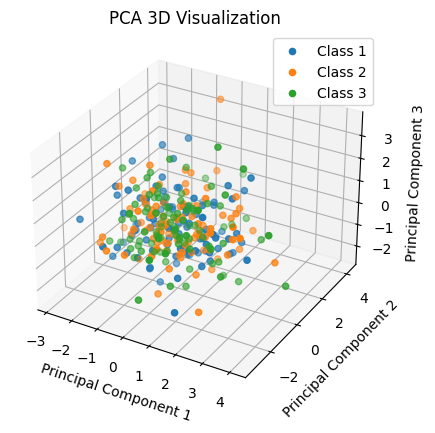

In [5]:
# 设置每个类的样本数量
num_samples = 100

# 设置每个类的维度
dim = 10

# 生成类内紧密的簇
class1_mean = torch.randn(dim) * 0.1
class2_mean = torch.randn(dim) * 0.1 + 20
class3_mean = torch.randn(dim) * 0.1 + 40

# 生成类内数据点
class1_samples = torch.randn(num_samples, dim) + class1_mean
class2_samples = torch.randn(num_samples, dim) + class2_mean
class3_samples = torch.randn(num_samples, dim) + class3_mean


# 将数据进行主成分分析降维到三维
pca = PCA(n_components=3)
class1_pca = pca.fit_transform(class1_samples)
class2_pca = pca.fit_transform(class2_samples)
class3_pca = pca.fit_transform(class3_samples)
print(class1_samples.size(), class1_pca.shape)

# 创建三维散点图
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# 绘制三维散点图
ax.scatter(class1_pca[:, 0], class1_pca[:, 1], class1_pca[:, 2], label='Class 1')
ax.scatter(class2_pca[:, 0], class2_pca[:, 1], class2_pca[:, 2], label='Class 2')
ax.scatter(class3_pca[:, 0], class3_pca[:, 1], class3_pca[:, 2], label='Class 3')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('PCA 3D Visualization')
ax.legend()

plt.show()

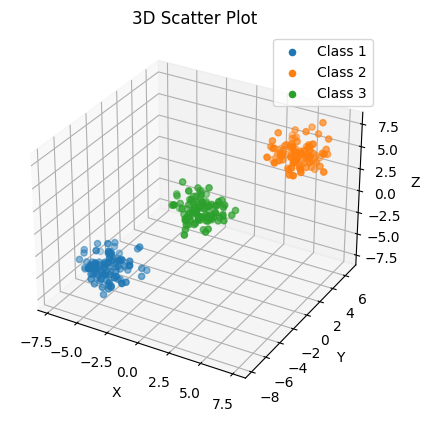

In [6]:
# 生成三个明显分离的簇
num_samples = 100
dim = 3

np.random.seed(0)

# 生成三个簇的中心点
center1 = np.array([-5, -5, -5])
center2 = np.array([5, 5, 5])
center3 = np.array([0, 0, 0])

# 生成数据点
class1_samples_3d = np.random.randn(num_samples, dim) + center1
class2_samples_3d = np.random.randn(num_samples, dim) + center2
class3_samples_3d = np.random.randn(num_samples, dim) + center3

# 绘制三维散点图
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# 绘制三个簇的数据点
ax.scatter(class1_samples_3d[:, 0], class1_samples_3d[:, 1], class1_samples_3d[:, 2], label='Class 1')
ax.scatter(class2_samples_3d[:, 0], class2_samples_3d[:, 1], class2_samples_3d[:, 2], label='Class 2')
ax.scatter(class3_samples_3d[:, 0], class3_samples_3d[:, 1], class3_samples_3d[:, 2], label='Class 3')

# 设置坐标轴标签和图标题
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Scatter Plot')

# 添加图例
ax.legend()

plt.show()


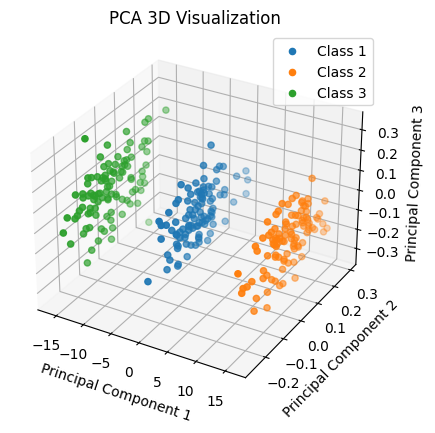

In [7]:
# 生成三类十维数据点
num_samples = 100
dim = 10

# 生成第一类数据点，位于原点附近
class1_samples_10d = np.random.normal(loc=0, scale=0.1, size=(num_samples, dim))

# 生成第二类数据点，位于 (5, 5, ..., 5) 处
class2_samples_10d = np.random.normal(loc=5, scale=0.1, size=(num_samples, dim))

# 生成第三类数据点，位于 (-5, -5, ..., -5) 处
class3_samples_10d = np.random.normal(loc=-5, scale=0.1, size=(num_samples, dim))

# 合并三类数据
all_samples_10d = np.vstack([class1_samples_10d, class2_samples_10d, class3_samples_10d])

# 使用 PCA 将数据降维到三维
pca = PCA(n_components=3)
all_samples_10d23d = pca.fit_transform(all_samples_10d)

# 绘制三维散点图
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(all_samples_10d23d[:num_samples, 0], all_samples_10d23d[:num_samples, 1], all_samples_10d23d[:num_samples, 2], label='Class 1')
ax.scatter(all_samples_10d23d[num_samples:2*num_samples, 0], all_samples_10d23d[num_samples:2*num_samples, 1], all_samples_10d23d[num_samples:2*num_samples, 2], label='Class 2')
ax.scatter(all_samples_10d23d[2*num_samples:, 0], all_samples_10d23d[2*num_samples:, 1], all_samples_10d23d[2*num_samples:, 2], label='Class 3')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('PCA 3D Visualization')
ax.legend()
plt.show()


## 处理10的数据，为每个数据加上标签，然后打乱

In [8]:
# 这里假设已经将数据集按类别分组好了，并且每个类别的数据点在一个独立的数组中
class1_samples_with_label = np.hstack((class1_samples_10d, np.ones((class1_samples.shape[0], 1)) * 0))
class2_samples_with_label = np.hstack((class2_samples_10d, np.ones((class2_samples.shape[0], 1)) * 1))
class3_samples_with_label = np.hstack((class3_samples_10d, np.ones((class3_samples.shape[0], 1)) * 2))

# 合并三类数据
all_samples_with_label = np.vstack([class1_samples_with_label, class2_samples_with_label, class3_samples_with_label])

# 打乱数据
np.random.shuffle(all_samples_with_label)

# 分离特征和标签
X = all_samples_with_label[:, :-1]
y = all_samples_with_label[:, -1]

# 划分数据集为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [31]:
# 定义MLP模型
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, output_dim)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        probs = self.softmax(x)
        
        return probs
    
    def get_embedding(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x
# 初始化模型、损失函数和优化器
input_dim = X_train.shape[1]    # 输入维度
output_dim = 3  # 设定输出维度为10，即所需的embedding维度
model = MLP(input_dim, output_dim).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [33]:
# 将数据转换为张量
X_train_tensor = torch.tensor(X_train, dtype=torch.float32, device=device)
y_train_tensor = torch.tensor(y_train, dtype=torch.long,device=device)

# 训练模型
num_epochs = 200
for epoch in range(num_epochs):
    model.train()  # 设置模型为训练模式
    optimizer.zero_grad()  # 清零梯度

    # 前向传播
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    
    # 反向传播和优化
    loss.backward()
    optimizer.step()

    # 打印训练信息
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [10/200], Loss: 0.5686
Epoch [20/200], Loss: 0.5623
Epoch [30/200], Loss: 0.5589
Epoch [40/200], Loss: 0.5569
Epoch [50/200], Loss: 0.5557
Epoch [60/200], Loss: 0.5548
Epoch [70/200], Loss: 0.5542
Epoch [80/200], Loss: 0.5538
Epoch [90/200], Loss: 0.5535
Epoch [100/200], Loss: 0.5532
Epoch [110/200], Loss: 0.5530
Epoch [120/200], Loss: 0.5528
Epoch [130/200], Loss: 0.5527
Epoch [140/200], Loss: 0.5526
Epoch [150/200], Loss: 0.5525
Epoch [160/200], Loss: 0.5524
Epoch [170/200], Loss: 0.5523
Epoch [180/200], Loss: 0.5522
Epoch [190/200], Loss: 0.5522
Epoch [200/200], Loss: 0.5521


In [34]:
outputs = model(X_train_tensor)
# print(outputs.argmax(dim=1) == y_train_tensor)

In [35]:
X_test_tensor = torch.tensor(X_test, dtype=torch.float32, device=device)
y_test_tensor = torch.tensor(y_test, dtype=torch.long,device=device)
# 在测试集上评估模型
model.eval()  # 设置模型为评估模式
with torch.no_grad():
    outputs = model(X_test_tensor)
    _, predicted = torch.max(outputs, 1)
    correct = (predicted == y_test_tensor).sum().item()
    total = y_test_tensor.size(0)
    accuracy = correct / total
    print(f'Test Accuracy: {accuracy:.4f}')

Test Accuracy: 1.0000


In [36]:
# 提取embedding
model.eval()
with torch.no_grad():
    X_train_embedding = model.get_embedding(X_train_tensor)
    X_test_embedding = model.get_embedding(X_test_tensor)

# 打印训练集和测试集的embedding形状
print("Training set embedding shape:", X_train_embedding.shape)
print("Test set embedding shape:", X_test_embedding.shape)

Training set embedding shape: torch.Size([240, 3])
Test set embedding shape: torch.Size([60, 3])


In [37]:
total_embeddings = torch.cat((X_train_embedding, X_test_embedding), dim=0)
toral_y = torch.cat((y_train_tensor, y_test_tensor), dim=0)
print(total_embeddings.shape)

torch.Size([300, 3])


In [38]:
from torch.nn.functional import cosine_similarity
from torch.nn.functional import pairwise_distance

def calculate_similarity(vector, vectors, mode='cosine'):
    """
    计算一个向量与一组向量之间的相似度。
    
    参数:
        vector (Tensor): 一个向量。
        vectors (Tensor): 一组向量。
        mode (str): 相似度计算模式。可选项包括 'cosine'、'euclidean'、'manhattan'。
        
    返回:
        Tensor: 相似度分数。
    """
    if mode == 'cosine':
        # 计算余弦相似度
        similarity = cosine_similarity(vector.unsqueeze(0), vectors)
    elif mode == 'euclidean':
        # 计算欧氏距离
        similarity = -pairwise_distance(vector.unsqueeze(0), vectors, p=2) ** 2
    elif mode == 'manhattan':
        # 计算曼哈顿距离（L1范数）
        similarity = -pairwise_distance(vector.unsqueeze(0), vectors, p=1)
    else:
        raise ValueError("Unsupported mode. Choose from 'cosine', 'euclidean', 'manhattan'.")
    
    return similarity

# 示例
vector = torch.tensor([1.0, 2.0, 3.0])
vectors = torch.tensor([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0], [7.0, 8.0, 9.0]])

# 计算余弦相似度
cosine_sim = calculate_similarity(vector, vectors, mode='cosine')
print('Cosine Similarity:', cosine_sim)

# 计算欧氏距离
euclidean_dist = calculate_similarity(vector, vectors, mode='euclidean')
print('Euclidean Distance:', euclidean_dist)

# 计算曼哈顿距离
manhattan_dist = calculate_similarity(vector, vectors, mode='manhattan')
print('Manhattan Distance:', manhattan_dist)


Cosine Similarity: tensor([1.0000, 0.9746, 0.9594])
Euclidean Distance: tensor([-3.0000e-12, -2.7000e+01, -1.0800e+02])
Manhattan Distance: tensor([-3.0000e-06, -9.0000e+00, -1.8000e+01])


In [39]:
# 对获取的embedding进行动态原型学习
prototype_vectors = total_embeddings[0].unsqueeze(0)
i = 0

for embedding in total_embeddings:
    similaritys = calculate_similarity(embedding, prototype_vectors, mode='cosine')
    wp, p = torch.max(similaritys, dim=0)
    print(f"{i}:", prototype_vectors.shape, similaritys.shape, wp, p)
    i += 1
    if wp >= 0.5:
        if prototype_vectors.shape[0] < 2:
            yita = 0.9
            prototype_vectors[p] = yita * prototype_vectors[p] + (1 - yita) * embedding
        else:
            prototype_vectors_no_p = torch.cat((prototype_vectors[:p], prototype_vectors[p + 1:]), dim=0)
            similaritys_no_p = calculate_similarity(prototype_vectors[p], prototype_vectors_no_p, mode='cosine')
            wq, q = torch.max(similaritys_no_p, dim=0)
            prototype_vectors[p] = (wp / (wq + wp)) * prototype_vectors[p] + (wq / (wq + wp)) * embedding
    else:
        prototype_vectors = torch.cat((prototype_vectors, embedding.unsqueeze(0)), dim=0)


0: torch.Size([1, 3]) torch.Size([1]) tensor(1., device='cuda:0') tensor(0, device='cuda:0')
1: torch.Size([1, 3]) torch.Size([1]) tensor(-0.8234, device='cuda:0') tensor(0, device='cuda:0')
2: torch.Size([2, 3]) torch.Size([2]) tensor(1.0000, device='cuda:0') tensor(1, device='cuda:0')
3: torch.Size([2, 3]) torch.Size([2]) tensor(-0.0147, device='cuda:0') tensor(0, device='cuda:0')
4: torch.Size([3, 3]) torch.Size([3]) tensor(0.9994, device='cuda:0') tensor(0, device='cuda:0')
5: torch.Size([3, 3]) torch.Size([3]) tensor(0.9993, device='cuda:0') tensor(1, device='cuda:0')
6: torch.Size([3, 3]) torch.Size([3]) tensor(0.9992, device='cuda:0') tensor(1, device='cuda:0')
7: torch.Size([3, 3]) torch.Size([3]) tensor(0.9997, device='cuda:0') tensor(0, device='cuda:0')
8: torch.Size([3, 3]) torch.Size([3]) tensor(0.9992, device='cuda:0') tensor(1, device='cuda:0')
9: torch.Size([3, 3]) torch.Size([3]) tensor(0.9996, device='cuda:0') tensor(1, device='cuda:0')
10: torch.Size([3, 3]) torch.Siz

In [40]:
print(prototype_vectors)
print(total_embeddings[toral_y == 2].shape)

tensor([[  0.1582,   9.3904,  -9.8132],
        [ -6.3012, -14.3583,   5.3178],
        [  3.9316,  -2.6329,  -2.4525]], device='cuda:0')
torch.Size([100, 3])


In [41]:
for prototype in prototype_vectors:
    print(nn.functional.cosine_similarity(total_embeddings[toral_y == 0], prototype))
    print(nn.functional.cosine_similarity(total_embeddings[toral_y == 1], prototype))
    print(nn.functional.cosine_similarity(total_embeddings[toral_y == 2], prototype))
    print()

tensor([ 8.5497e-04,  2.7586e-03, -2.2696e-03, -1.2745e-03,  7.7350e-03,
        -9.8970e-04,  1.4467e-03,  9.8519e-03,  2.2626e-03,  8.2779e-03,
         3.5410e-03,  8.6074e-03,  3.4857e-03, -5.1233e-03,  9.6796e-03,
         2.3907e-03,  2.6185e-03,  8.0125e-03,  5.5659e-03,  6.4567e-03,
        -3.9611e-03,  3.8853e-03, -5.6062e-03,  2.3101e-03,  8.5469e-03,
        -3.9950e-05,  2.8190e-03, -3.5462e-04,  3.7974e-03,  4.6339e-05,
         9.2328e-04,  3.0684e-03,  6.3198e-03,  1.6173e-03, -2.0902e-03,
         8.0939e-03,  3.8349e-03,  3.8814e-03, -3.0683e-04,  1.3184e-02,
         8.7126e-03, -4.4239e-03, -1.1249e-02,  3.4174e-03,  9.1052e-03,
         2.8141e-04,  4.4370e-03,  1.7809e-03,  1.7750e-03, -1.8426e-03,
         9.8277e-04,  1.6036e-03,  5.3518e-03, -3.4897e-03,  3.9235e-03,
         1.0614e-02,  6.8965e-03, -3.5353e-04, -3.7584e-03,  4.2400e-03,
         5.9671e-03,  2.5289e-03,  5.4607e-03,  6.8696e-03,  7.5815e-03,
         4.0565e-03,  7.9746e-03,  9.2510e-03,  2.1

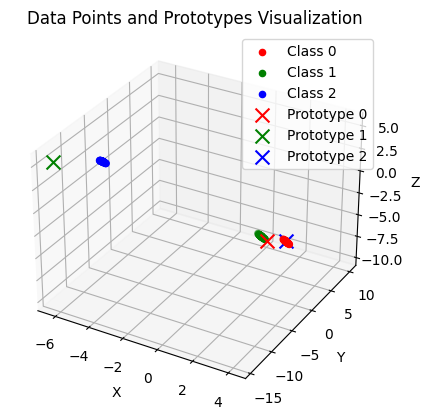

In [43]:
# 创建3D图形
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# 为每个类别设置不同的颜色
colors = ['r', 'g', 'b']  # 假设有三个类别

# 绘制数据点
for i in range(len(colors)):
    ax.scatter(total_embeddings[toral_y == i, 0].cpu(), total_embeddings[toral_y == i, 1].cpu(), total_embeddings[toral_y == i, 2].cpu(), c=colors[i], label=f'Class {i}')

# 绘制原型向量
for i, prototype in enumerate(prototype_vectors):
    ax.scatter(prototype[0].cpu(), prototype[1].cpu(), prototype[2].cpu(), c=colors[i], marker='x', s=100, label=f'Prototype {i}')

# 设置图形的标签和标题
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Data Points and Prototypes Visualization')

# 添加图例
ax.legend()

plt.show()
